# CNN for Helmet Detection with Pre-Extracted Areas of Interest

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.manual_seed(480)
np.random.seed(480)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Analysis and Preprocessing
First we will analyze the data and preprocess it to be ready for training our CNN model(s).

In [2]:
object_df = pd.read_csv('data/objects.csv', index_col='CroppedImage')
images_df = pd.read_csv('data/images.csv', index_col='filename')

We need to first encode our target feature `label` to be numerical.

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(['Without Helmet', 'With Helmet'])

object_df['label'] = label_encoder.transform(object_df['label'])

from sklearn.model_selection import train_test_split

train_images, test_images = train_test_split(images_df, test_size=0.2, random_state=480)

train_objects = object_df[object_df['filename'].isin(train_images.index)]
test_objects = object_df[object_df['filename'].isin(test_images.index)]

X_train = train_objects.drop(['label'], axis=1)
y_train = train_objects['label']

X_test = test_objects.drop(['label'], axis=1)
y_test = test_objects['label']

In [4]:
X_train

filename  xmin  ymin  xmax  ymax
CroppedImage                                             
0.jpg         BikesHelmets765.png   193    13   265    65
1.jpg         BikesHelmets759.png   148    99   172   123
2.jpg         BikesHelmets759.png   230   103   247   124
3.jpg         BikesHelmets759.png    64   102    88   125
4.jpg         BikesHelmets759.png   287    97   304   116
...                           ...   ...   ...   ...   ...
1442.jpg      BikesHelmets740.png   202    32   225    56
1443.jpg      BikesHelmets740.png   107    33   131    58
1444.jpg      BikesHelmets740.png    17    30    43    56
1445.jpg      BikesHelmets740.png   239    24   255    47
1446.jpg      BikesHelmets740.png    69    29    91    54

[1161 rows x 5 columns]

In [5]:
y_train

CroppedImage
0.jpg       0
1.jpg       0
2.jpg       1
3.jpg       1
4.jpg       1
           ..
1442.jpg    1
1443.jpg    1
1444.jpg    1
1445.jpg    1
1446.jpg    0
Name: label, Length: 1161, dtype: int64

CNNs generally require images with the same size. Therefore, we will try to see if our images are of similar size or if we need to resize them we will plot the image resolutions to see the distribution of the image sizes.

Text(0, 0.5, 'Height')

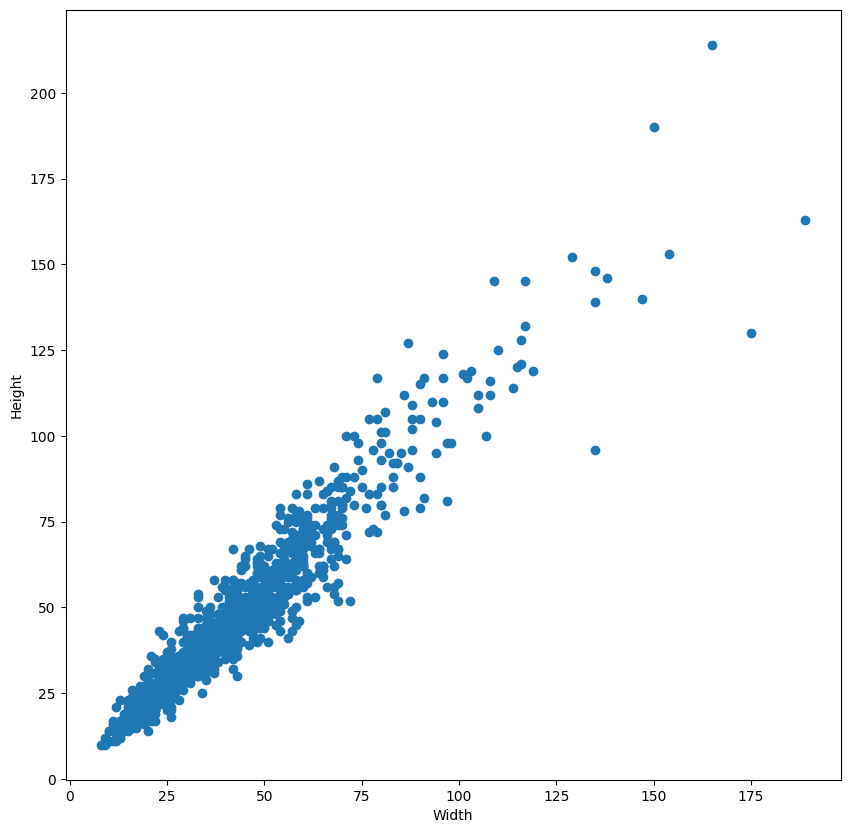

In [6]:
plt.figure(figsize=(10, 10))
plt.scatter(X_train['xmax']-X_train['xmin'], X_train['ymax']-X_train['ymin'])
plt.xlabel('Width')
plt.ylabel('Height')

From the plot we can see that the images are of different sizes. We could attempt to select multiple sizes with many images clustered around them and train multiple models with different sizes. However, since our dataset is small, we will resize all images to the same size. Let's zoom in to see where most of the images are clustered.

(0.0, 100.0)

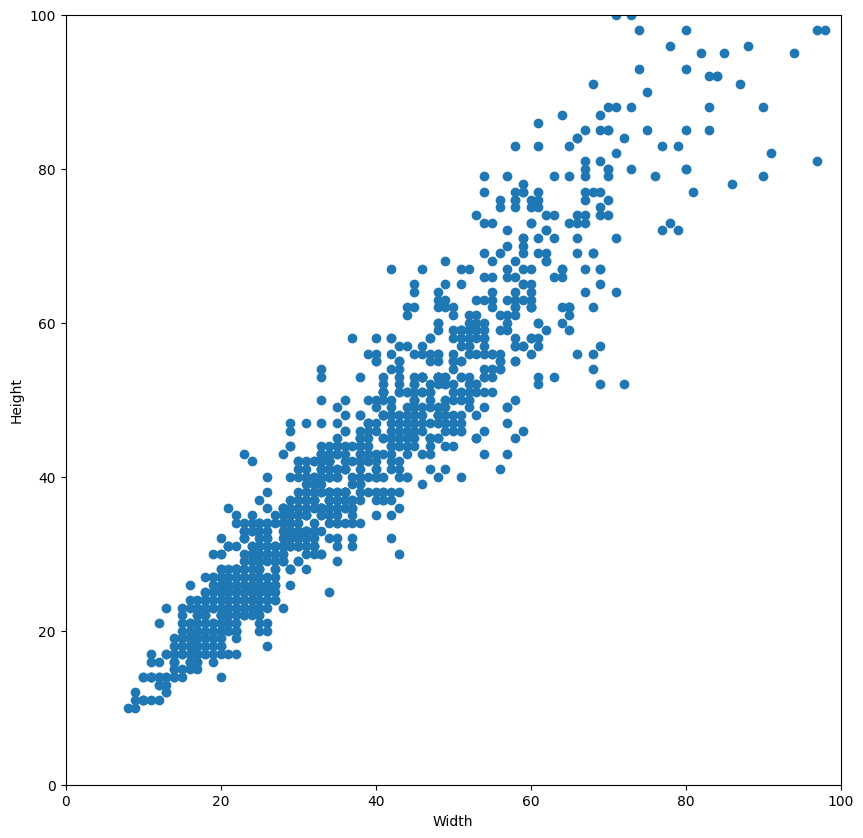

In [7]:
# Plot points where width and height are both less than 100

plt.figure(figsize=(10, 10))
plt.scatter(X_train['xmax']-X_train['xmin'], X_train['ymax']-X_train['ymin'])
plt.xlabel('Width')
plt.ylabel('Height')
plt.xlim(0, 100)
plt.ylim(0, 100)

While the densest patch in the zoomed in image is somewhere around 30x30, accounting for the images that were cropped when zooming in as well as other points, it seems that 45x45 is a good size to resize our images to. We will define a transformer that iterates over the object_df, loads the corresponding cropped image, and resizes it to 45x45 to start building our pipeline. 

In [8]:
from torchvision import transforms
from PIL import Image
import os

# ImageLoaderResizer is a callable class that takes in a row from a dataframe
class ImageLoaderResizer:
    def __init__(self, height, width, img_dir = 'data/cropped_images/'):
        self.img_dir = img_dir
        self.transforms = transforms.Compose([
            transforms.Resize((height, width)),
            transforms.ToTensor()
        ])
    
    def __call__(self, df_row):
        img_name = df_row.name
        img = Image.open(os.path.join(self.img_dir, img_name))
        return self.transforms(img)


In [9]:
# Initialize the ImageLoaderResizer class with height and width of 45 pixels
image_loader_resizer = ImageLoaderResizer(45, 45)

Shape of the first image: torch.Size([3, 45, 45])


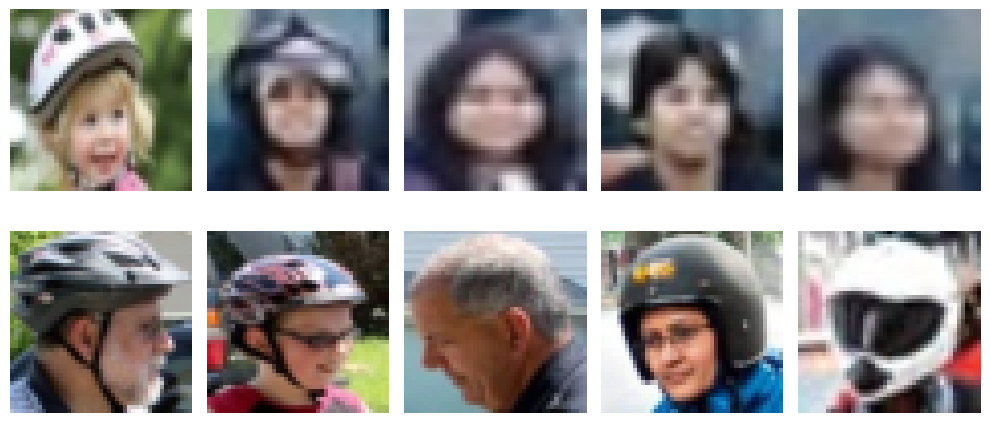

In [10]:
# display the shape of the first image
X_train_images = X_train.apply(image_loader_resizer, axis=1)

# display the shape of the first image
print(f"Shape of the first image: {X_train_images[0].shape}")

# Plot the first 10 images in the training set

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()
for img, ax in zip(X_train_images, axes):
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
plt.tight_layout()
plt.show()

# Delete X_train_images to free up memory
del X_train_images

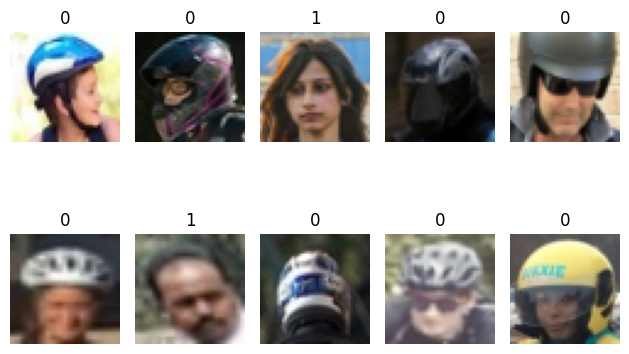

In [11]:
# Now that we have ImageLoaderResizer, we can use it to create a dataset object that we can use to train our model.

from torch.utils.data import Dataset

class ObjectDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        row = self.X.iloc[idx]
        img = self.transform(row)
        label = self.y.iloc[idx]
        return img, label
    
train_dataset = ObjectDataset(X_train, y_train, transform=image_loader_resizer)

# Now that we have a dataset object, we can use it to create a dataloader object that we can use to train our model.

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for img, label in train_dataloader:
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(img[i].permute(1, 2, 0))
        plt.title(label[i].item())
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

# The dataloader loads the data in batches of 32 images. The


In [12]:
# Now that we have a dataloader object, we can use it to train our CNN model.

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ObjectClassifier(nn.Module):
    def __init__(self , classes, conv_layer_out_channels_kernel_size, in_channels=3, dropout_p=0.5, img_height=45, img_width=45):
        super(
            ObjectClassifier,
            self).__init__()
        
        for i in range(len(conv_layer_out_channels_kernel_size)):
            if i == 0:
                self.conv_layers = nn.Sequential(
                    nn.Conv2d(in_channels, conv_layer_out_channels_kernel_size[i][0], conv_layer_out_channels_kernel_size[i][1]),
                    nn.ReLU(),
                    nn.MaxPool2d(2)
                )
            else:
                self.conv_layers.add_module(f'conv_{i+1}', nn.Conv2d(conv_layer_out_channels_kernel_size[i-1][0], conv_layer_out_channels_kernel_size[i][0], conv_layer_out_channels_kernel_size[i][1]))
                self.conv_layers.add_module(f'relu_{i+1}', nn.ReLU())
                self.conv_layers.add_module(f'maxpool_{i+1}', nn.MaxPool2d(2))

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_p),
        )

        conv_h = self.conv_layers(torch.zeros(1, in_channels, img_height, img_width)).shape[2]
        conv_w = self.conv_layers(torch.zeros(1, in_channels, img_height, img_width)).shape[3]

        self.fc_layers.add_module('fc1', nn.Linear(conv_h * conv_w * conv_layer_out_channels_kernel_size[-1][0], 128))
        self.fc_layers.add_module('relu1', nn.ReLU())
        self.fc_layers.add_module('dropout1', nn.Dropout(dropout_p))
        self.fc_layers.add_module('fc2', nn.Linear(128, classes))
        self.fc_layers.add_module('output', nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    

Epoch 1/50.. Train loss: 0.586.. Train accuracy: 0.666
Epoch 2/50.. Train loss: 0.460.. Train accuracy: 0.781
Epoch 3/50.. Train loss: 0.414.. Train accuracy: 0.820
Epoch 4/50.. Train loss: 0.395.. Train accuracy: 0.837
Epoch 5/50.. Train loss: 0.372.. Train accuracy: 0.845
Epoch 6/50.. Train loss: 0.362.. Train accuracy: 0.838
Epoch 7/50.. Train loss: 0.350.. Train accuracy: 0.853
Epoch 8/50.. Train loss: 0.343.. Train accuracy: 0.868
Epoch 9/50.. Train loss: 0.339.. Train accuracy: 0.858
Epoch 10/50.. Train loss: 0.318.. Train accuracy: 0.867
Epoch 11/50.. Train loss: 0.285.. Train accuracy: 0.874
Epoch 12/50.. Train loss: 0.284.. Train accuracy: 0.889
Epoch 13/50.. Train loss: 0.295.. Train accuracy: 0.880
Epoch 14/50.. Train loss: 0.278.. Train accuracy: 0.878
Epoch 15/50.. Train loss: 0.251.. Train accuracy: 0.904
Epoch 16/50.. Train loss: 0.237.. Train accuracy: 0.903
Epoch 17/50.. Train loss: 0.243.. Train accuracy: 0.906
Epoch 18/50.. Train loss: 0.227.. Train accuracy: 0.905
E

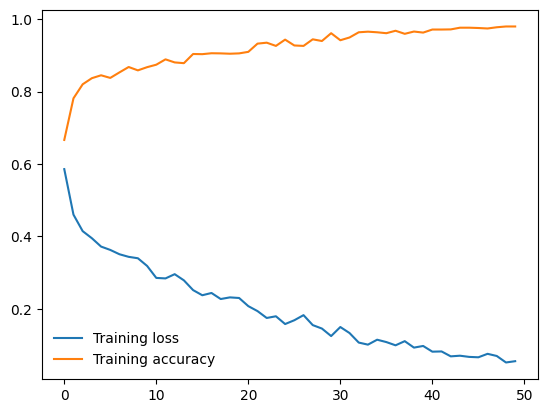

In [13]:
model_1 = ObjectClassifier(2, [(16, 3), (32, 3)], dropout_p=0.4)
model_1.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

epochs = 50
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model_1(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))
    train_losses.append(train_loss/len(train_dataloader))
    train_accuracies.append(train_accuracy/len(train_dataloader))
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss/len(train_dataloader):.3f}.. "
          f"Train accuracy: {train_accuracy/len(train_dataloader):.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(train_accuracies, label='Training accuracy')
plt.legend(frameon=False)
plt.savefig('output/model_tl_ta.png', dpi=300)
plt.show()

# Save the model
torch.save(model_1.state_dict(), 'models/model_1.pt')

Test loss: 0.520.. Test accuracy: 0.884


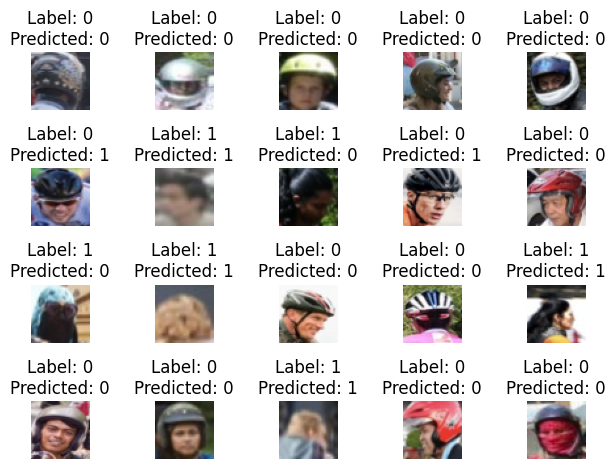

In [14]:
# Now that we have trained our model, we can use it to make predictions on the test set, we can also visualize the predictions.
# We will compute the test loss and test accuracy and then plot the first 20 images in the test set with their labels and predictions.
model_1 = ObjectClassifier(2, [(16, 3), (32, 3)], dropout_p=0.5)
model_1.load_state_dict(torch.load('models/model_1.pt'))


test_dataset = ObjectDataset(X_test, y_test, transform=image_loader_resizer)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

test_loss = 0
test_accuracy = 0
model_1.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_1(images)
        loss = criterion(log_ps, labels)
        test_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    print(f"Test loss: {test_loss/len(test_dataloader):.3f}.. "
          f"Test accuracy: {test_accuracy/len(test_dataloader):.3f}")
    
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_1(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        images = images.to(device)
        labels = labels.to(device)
        top_class = top_class.to(device)
        equals = equals.to(device)
        for i in range(20):
            plt.subplot(4, 5, i+1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(f"Label: {labels[i].item()}\nPredicted: {top_class[i].item()}")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig('output/model_1_predictions.png', dpi=300)
        plt.show()
        break

ROC AUC: 0.812


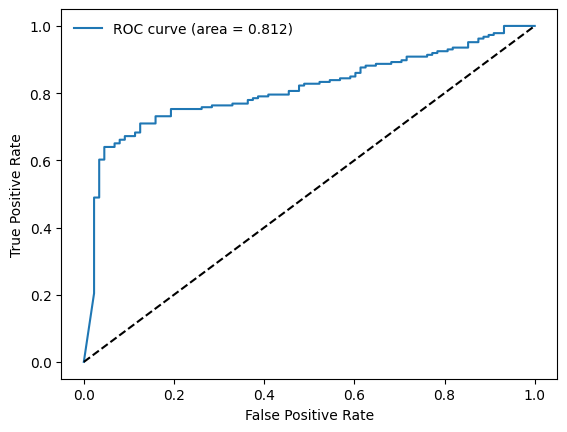

In [15]:
# Let's evaluate the true positive rate and false positive rate of our model.
model_1 = ObjectClassifier(2, [(16, 3), (32, 3)], dropout_p=0.4)
model_1.load_state_dict(torch.load('models/model_1.pt'))

from sklearn.metrics import roc_curve, auc

model_1.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_1(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        y_pred.extend(top_p.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=0)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.3f}")

# Let's plot the ROC curve.

plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(frameon=False)
plt.savefig('output/model_1_roc.png', dpi=300)
plt.show()

Epoch 1/50.. Train loss: 0.619.. Train accuracy: 0.654
Epoch 2/50.. Train loss: 0.524.. Train accuracy: 0.710
Epoch 3/50.. Train loss: 0.453.. Train accuracy: 0.791
Epoch 4/50.. Train loss: 0.402.. Train accuracy: 0.820
Epoch 5/50.. Train loss: 0.391.. Train accuracy: 0.833
Epoch 6/50.. Train loss: 0.388.. Train accuracy: 0.831
Epoch 7/50.. Train loss: 0.382.. Train accuracy: 0.825
Epoch 8/50.. Train loss: 0.372.. Train accuracy: 0.833
Epoch 9/50.. Train loss: 0.365.. Train accuracy: 0.842
Epoch 10/50.. Train loss: 0.345.. Train accuracy: 0.848
Epoch 11/50.. Train loss: 0.348.. Train accuracy: 0.856
Epoch 12/50.. Train loss: 0.352.. Train accuracy: 0.861
Epoch 13/50.. Train loss: 0.326.. Train accuracy: 0.866
Epoch 14/50.. Train loss: 0.334.. Train accuracy: 0.857
Epoch 15/50.. Train loss: 0.306.. Train accuracy: 0.877
Epoch 16/50.. Train loss: 0.308.. Train accuracy: 0.869
Epoch 17/50.. Train loss: 0.300.. Train accuracy: 0.882
Epoch 18/50.. Train loss: 0.291.. Train accuracy: 0.875
E

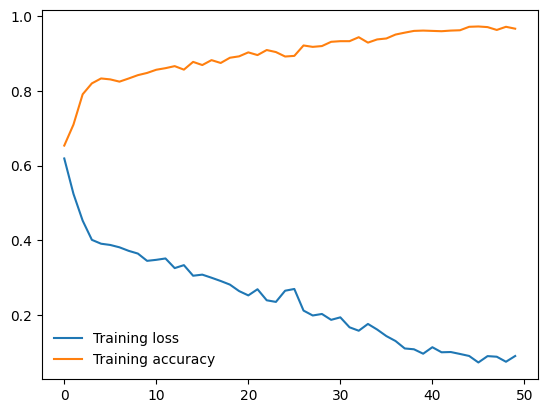

In [16]:
# Our model has a low ROC AUC of 0.781. Let's try to improve it by adding more convolutional layers to our model.

model_2 = ObjectClassifier(2, [(16, 3), (32, 3), (64, 3)], dropout_p=0.4)
model_2.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

epochs = 50
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model_2(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))
    train_losses.append(train_loss/len(train_dataloader))
    train_accuracies.append(train_accuracy/len(train_dataloader))
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss/len(train_dataloader):.3f}.. "
          f"Train accuracy: {train_accuracy/len(train_dataloader):.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(train_accuracies, label='Training accuracy')
plt.legend(frameon=False)
plt.savefig('output/model_2_tl_ta.png', dpi=300)
plt.show()

# Save the model
torch.save(model_2.state_dict(), 'models/model_2.pt')

Test loss: 0.336.. Test accuracy: 0.894


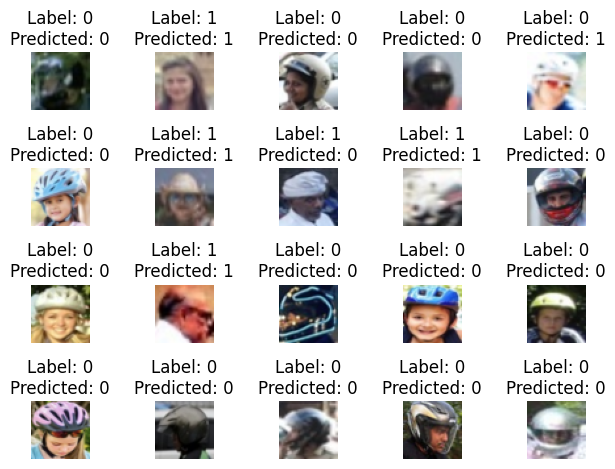

In [17]:
# Test the model
model_2 = ObjectClassifier(2, [(16, 3), (32, 3), (64, 3)], dropout_p=0.4)
model_2.load_state_dict(torch.load('models/model_2.pt'))

test_loss = 0
test_accuracy = 0
model_2.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_2(images)
        loss = criterion(log_ps, labels)
        test_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    print(f"Test loss: {test_loss/len(test_dataloader):.3f}.. "
          f"Test accuracy: {test_accuracy/len(test_dataloader):.3f}")
    
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_2(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        images = images.to(device)
        labels = labels.to(device)
        top_class = top_class.to(device)
        equals = equals.to(device)
        for i in range(20):
            plt.subplot(4, 5, i+1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(f"Label: {labels[i].item()}\nPredicted: {top_class[i].item()}")
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('output/model_2_predictions.png', dpi=300)
        plt.show()
        break

ROC AUC: 0.628


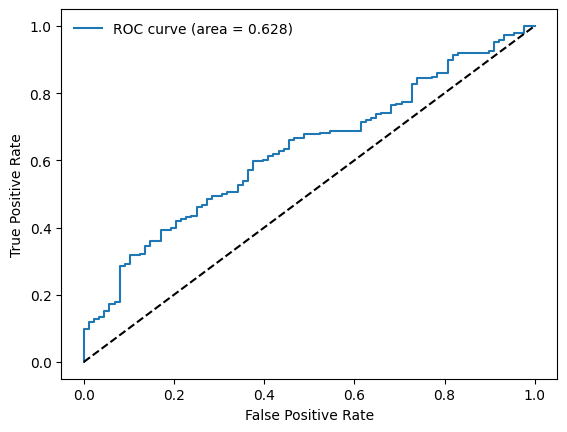

In [18]:
# Let's evaluate the true positive rate and false positive rate of our model.
model_2 = ObjectClassifier(2, [(16, 3), (32, 3), (64, 3)], dropout_p=0.4)
model_2.load_state_dict(torch.load('models/model_2.pt'))

from sklearn.metrics import roc_curve, auc

model_2.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_2(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        y_pred.extend(top_p.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=0)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.3f}")

# Let's plot the ROC curve.

plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(frameon=False)
plt.savefig('output/model_2_roc.png', dpi=300)
plt.show()

Epoch 1/50.. Train loss: 0.648.. Train accuracy: 0.635
Epoch 2/50.. Train loss: 0.546.. Train accuracy: 0.702
Epoch 3/50.. Train loss: 0.428.. Train accuracy: 0.806
Epoch 4/50.. Train loss: 0.408.. Train accuracy: 0.810
Epoch 5/50.. Train loss: 0.391.. Train accuracy: 0.839
Epoch 6/50.. Train loss: 0.388.. Train accuracy: 0.823
Epoch 7/50.. Train loss: 0.370.. Train accuracy: 0.844
Epoch 8/50.. Train loss: 0.372.. Train accuracy: 0.846
Epoch 9/50.. Train loss: 0.375.. Train accuracy: 0.844
Epoch 10/50.. Train loss: 0.377.. Train accuracy: 0.847
Epoch 11/50.. Train loss: 0.361.. Train accuracy: 0.841
Epoch 12/50.. Train loss: 0.348.. Train accuracy: 0.856
Epoch 13/50.. Train loss: 0.344.. Train accuracy: 0.866
Epoch 14/50.. Train loss: 0.331.. Train accuracy: 0.869
Epoch 15/50.. Train loss: 0.339.. Train accuracy: 0.854
Epoch 16/50.. Train loss: 0.327.. Train accuracy: 0.869
Epoch 17/50.. Train loss: 0.314.. Train accuracy: 0.877
Epoch 18/50.. Train loss: 0.305.. Train accuracy: 0.880
E

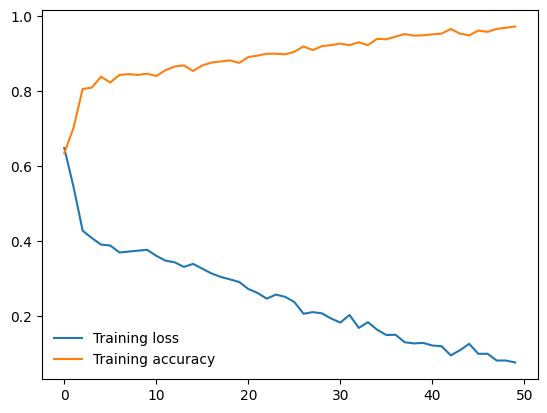

In [19]:
# Model 2 has a ROC AUC of 0.652, which is lower than Model 1. However, model 2 has a higher test accuracy, let's try using a different criterion to train our model.

model_3 = ObjectClassifier(2, [(16, 3), (32, 3), (64, 3)], dropout_p=0.4)
model_3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001)

epochs = 50
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model_3(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))
    train_losses.append(train_loss/len(train_dataloader))
    train_accuracies.append(train_accuracy/len(train_dataloader))
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss/len(train_dataloader):.3f}.. "
          f"Train accuracy: {train_accuracy/len(train_dataloader):.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(train_accuracies, label='Training accuracy')
plt.legend(frameon=False)
plt.savefig('output/model_3_tl_ta.png', dpi=300)
plt.show()

# Save the model
torch.save(model_3.state_dict(), 'models/model_3.pt')

Test loss: 0.375.. Test accuracy: 0.893


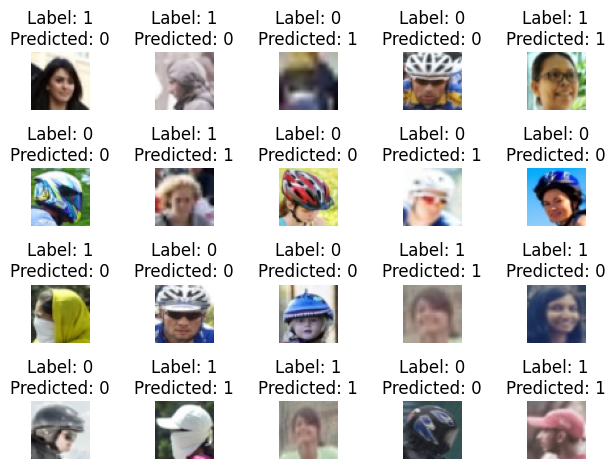

In [20]:
# Test the model
model_3 = ObjectClassifier(2, [(16, 3), (32, 3), (64, 3)], dropout_p=0.4)
model_3.load_state_dict(torch.load('models/model_3.pt'))

test_loss = 0
test_accuracy = 0
model_3.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_3(images)
        loss = criterion(log_ps, labels)
        test_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    print(f"Test loss: {test_loss/len(test_dataloader):.3f}.. "
          f"Test accuracy: {test_accuracy/len(test_dataloader):.3f}")
    
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_3(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        images = images.to(device)
        labels = labels.to(device)
        top_class = top_class.to(device)
        equals = equals.to(device)
        for i in range(20):
            plt.subplot(4, 5, i+1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(f"Label: {labels[i].item()}\nPredicted: {top_class[i].item()}")
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('output/model_3_predictions.png', dpi=300)
        plt.show()
        break

ROC AUC: 0.787


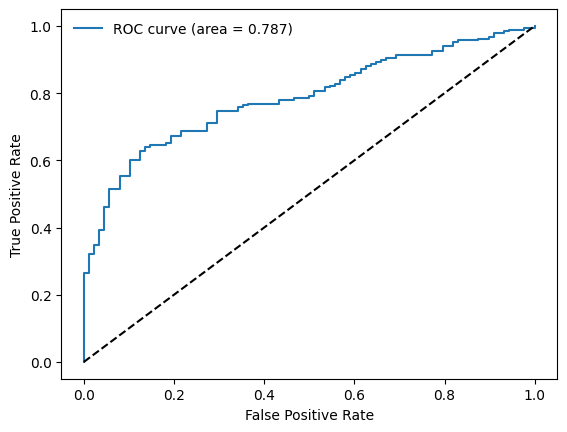

In [21]:
# Let's evaluate the true positive rate and false positive rate of our model.
model_3 = ObjectClassifier(2, [(16, 3), (32, 3), (64, 3)], dropout_p=0.4)
model_3.load_state_dict(torch.load('models/model_3.pt'))

from sklearn.metrics import roc_curve, auc

model_3.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_3(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        y_pred.extend(top_p.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=0)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.3f}")

# Let's plot the ROC curve.

plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(frameon=False)
plt.savefig('output/model_3_roc.png', dpi=300)
plt.show()

Epoch 1/50.. Train loss: 0.577.. Train accuracy: 0.687
Epoch 2/50.. Train loss: 0.472.. Train accuracy: 0.772
Epoch 3/50.. Train loss: 0.446.. Train accuracy: 0.794
Epoch 4/50.. Train loss: 0.409.. Train accuracy: 0.823
Epoch 5/50.. Train loss: 0.413.. Train accuracy: 0.820
Epoch 6/50.. Train loss: 0.385.. Train accuracy: 0.837
Epoch 7/50.. Train loss: 0.375.. Train accuracy: 0.829
Epoch 8/50.. Train loss: 0.344.. Train accuracy: 0.849
Epoch 9/50.. Train loss: 0.331.. Train accuracy: 0.869
Epoch 10/50.. Train loss: 0.323.. Train accuracy: 0.868
Epoch 11/50.. Train loss: 0.307.. Train accuracy: 0.880
Epoch 12/50.. Train loss: 0.316.. Train accuracy: 0.873
Epoch 13/50.. Train loss: 0.278.. Train accuracy: 0.880
Epoch 14/50.. Train loss: 0.292.. Train accuracy: 0.878
Epoch 15/50.. Train loss: 0.277.. Train accuracy: 0.887
Epoch 16/50.. Train loss: 0.243.. Train accuracy: 0.894
Epoch 17/50.. Train loss: 0.248.. Train accuracy: 0.898
Epoch 18/50.. Train loss: 0.228.. Train accuracy: 0.910
E

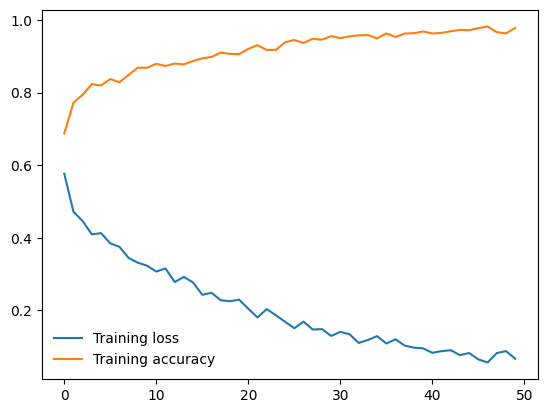

In [22]:
# Using CrossEntropyLoss as the criterion improved the ROC AUC to 0.814 with the same parameters as model 2. Let's see if the same criterion can improve model 1.

model_4 = ObjectClassifier(2, [(16, 3), (32, 3)], dropout_p=0.4)
model_4.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_4.parameters(), lr=0.001)

epochs = 50
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    train_loss = 0
    train_accuracy = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model_4(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))
    train_losses.append(train_loss/len(train_dataloader))
    train_accuracies.append(train_accuracy/len(train_dataloader))
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss/len(train_dataloader):.3f}.. "
          f"Train accuracy: {train_accuracy/len(train_dataloader):.3f}")
    
plt.plot(train_losses, label='Training loss')
plt.plot(train_accuracies, label='Training accuracy')
plt.legend(frameon=False)
plt.savefig('output/model_4_tl_ta.png', dpi=300)
plt.show()

# Save the model
torch.save(model_4.state_dict(), 'models/model_4.pt')

Test loss: 0.501.. Test accuracy: 0.880


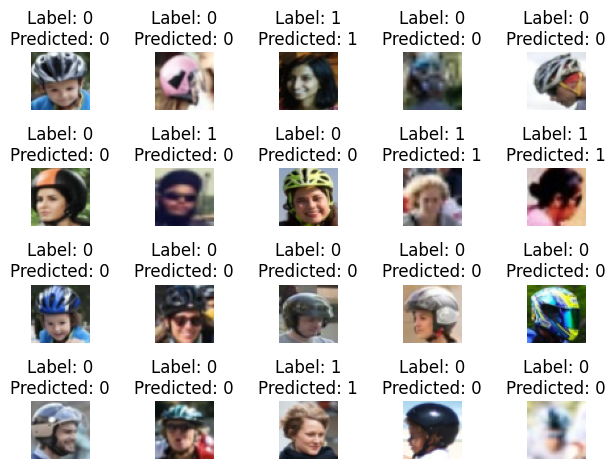

In [23]:
# Test the model
model_4 = ObjectClassifier(2, [(16, 3), (32, 3)], dropout_p=0.4)
model_4.load_state_dict(torch.load('models/model_4.pt'))

test_loss = 0
test_accuracy = 0
model_4.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_4(images)
        loss = criterion(log_ps, labels)
        test_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    print(f"Test loss: {test_loss/len(test_dataloader):.3f}.. "
          f"Test accuracy: {test_accuracy/len(test_dataloader):.3f}")
    
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_4(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        images = images.to(device)
        labels = labels.to(device)
        top_class = top_class.to(device)
        equals = equals.to(device)
        for i in range(20):
            plt.subplot(4, 5, i+1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(f"Label: {labels[i].item()}\nPredicted: {top_class[i].item()}")
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('output/model_4_predictions.png', dpi=300)
        plt.show()
        break

ROC AUC: 0.803


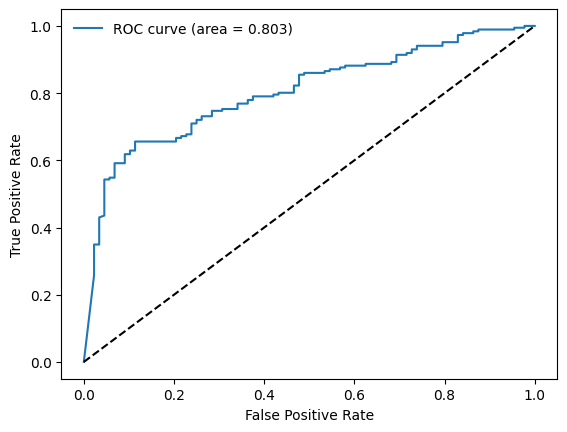

In [24]:
# Let's evaluate the true positive rate and false positive rate of our model.
model_4 = ObjectClassifier(2, [(16, 3), (32, 3)], dropout_p=0.4)
model_4.load_state_dict(torch.load('models/model_4.pt'))

from sklearn.metrics import roc_curve, auc

model_4.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_4(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        y_pred.extend(top_p.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=0)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.3f}")

# Let's plot the ROC curve.

plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(frameon=False)
plt.savefig('output/model_4_roc.png', dpi=300)
plt.show()

Test loss: 0.531.. Test accuracy: 0.879


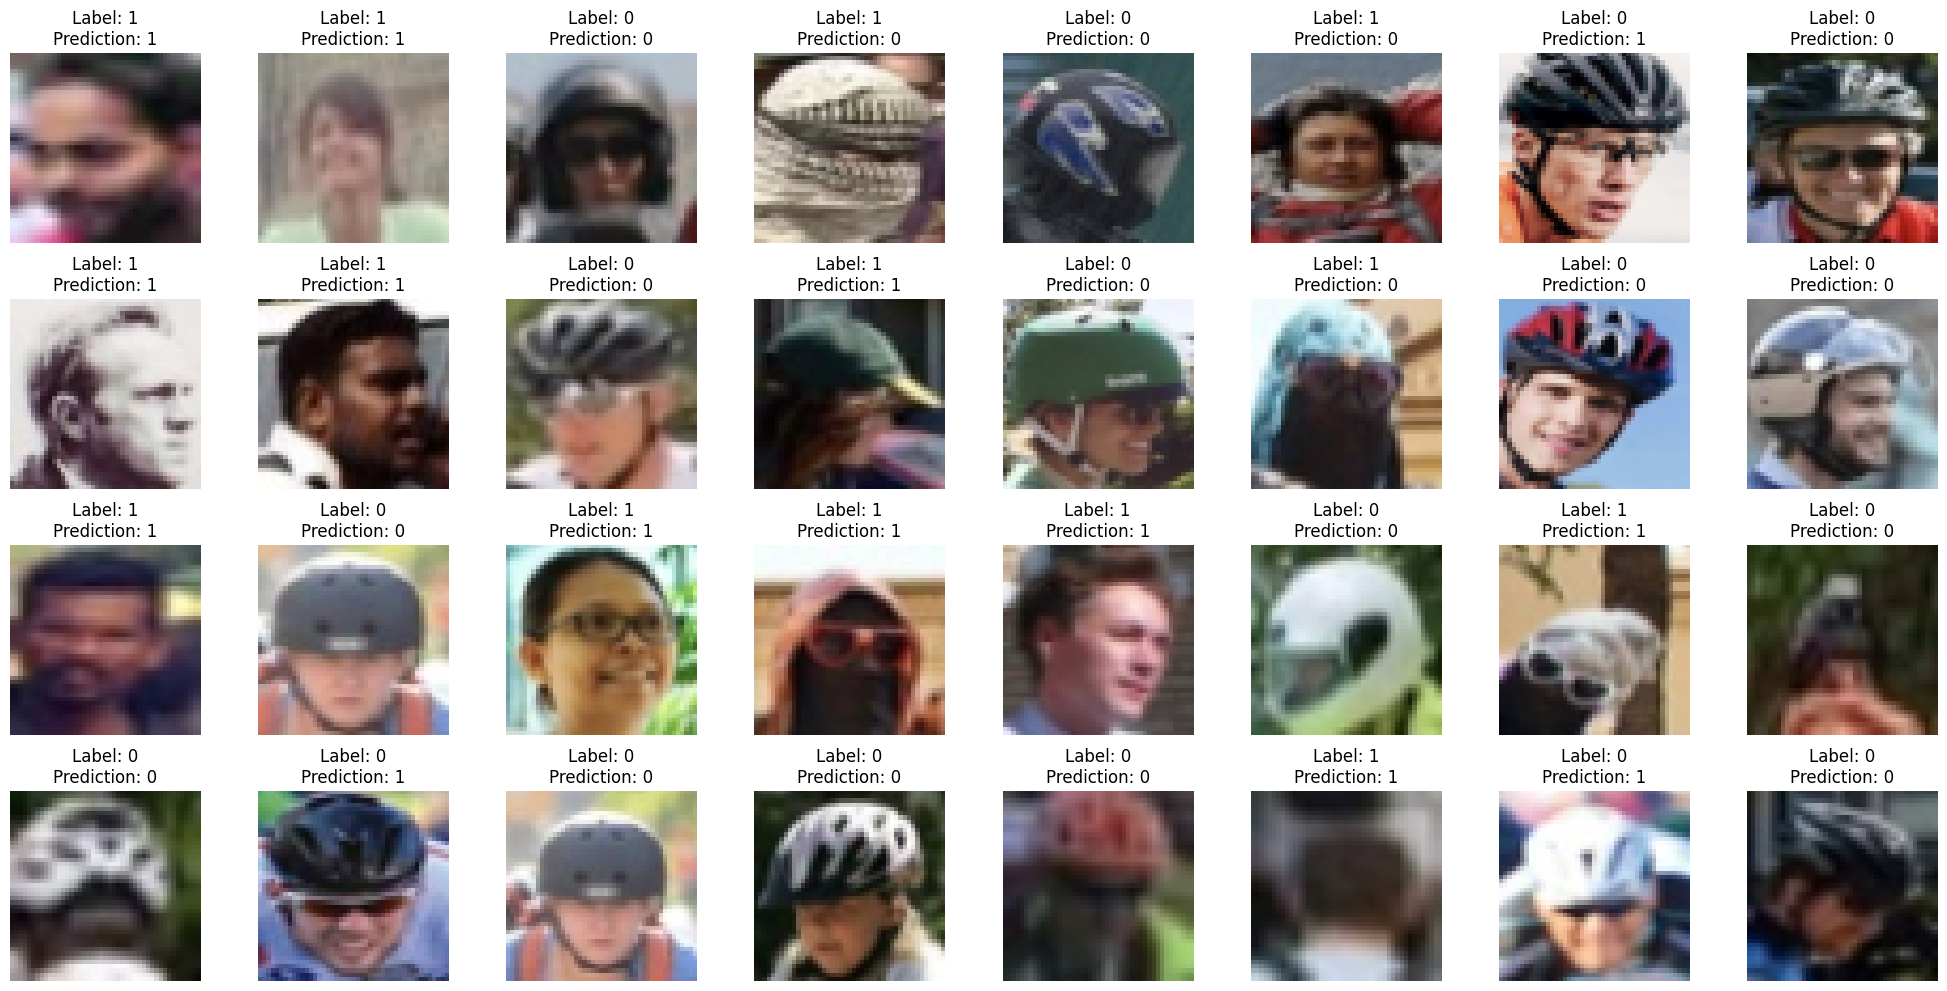

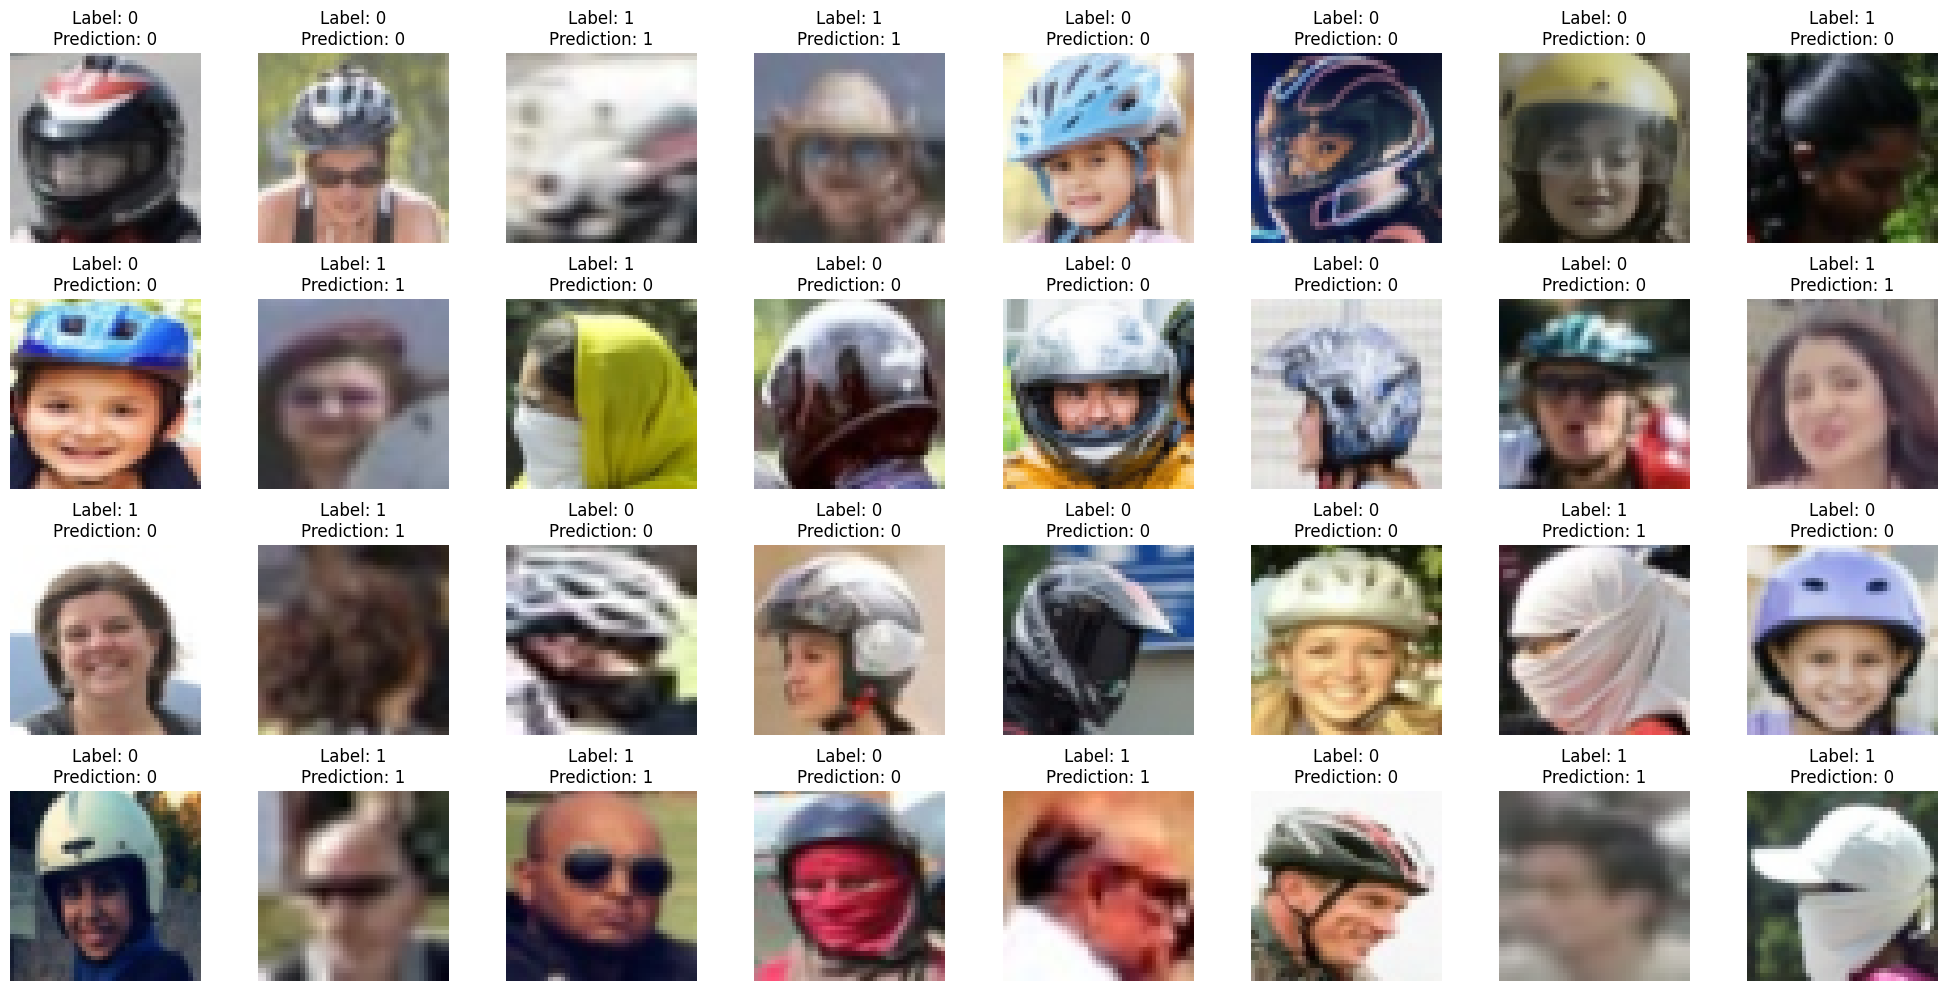

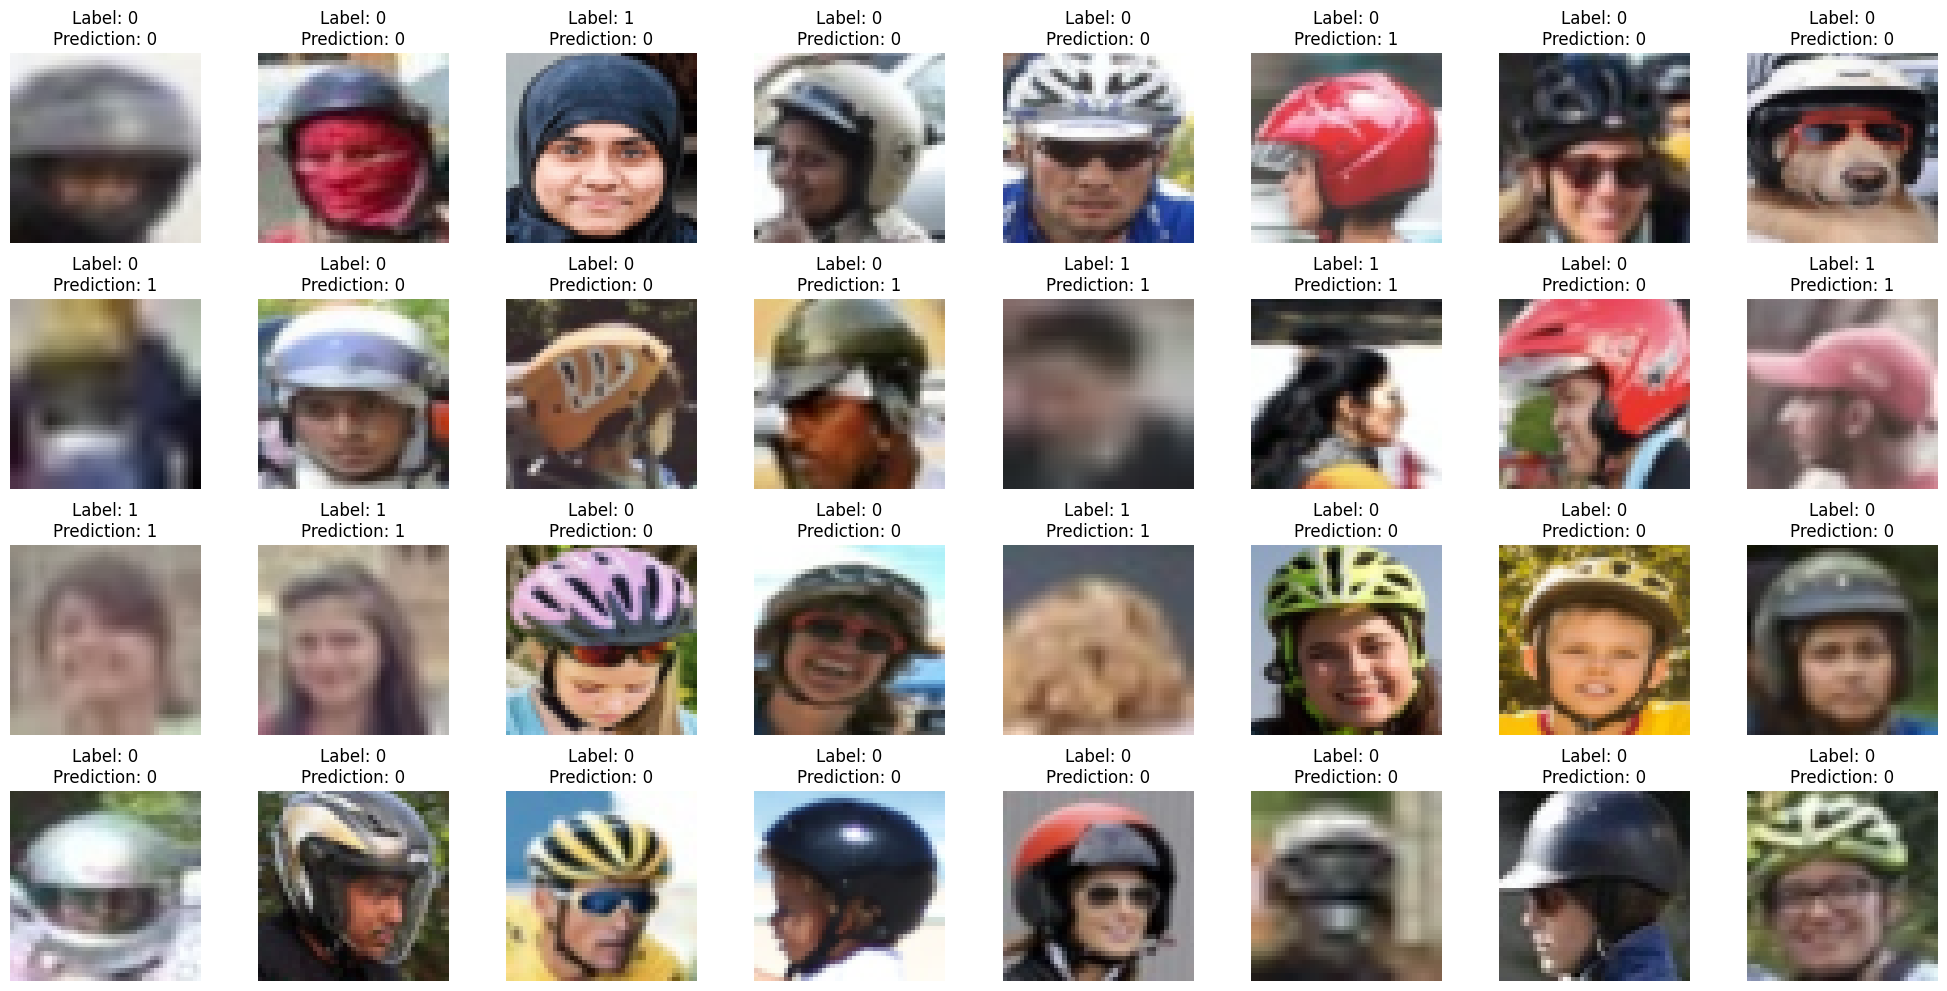

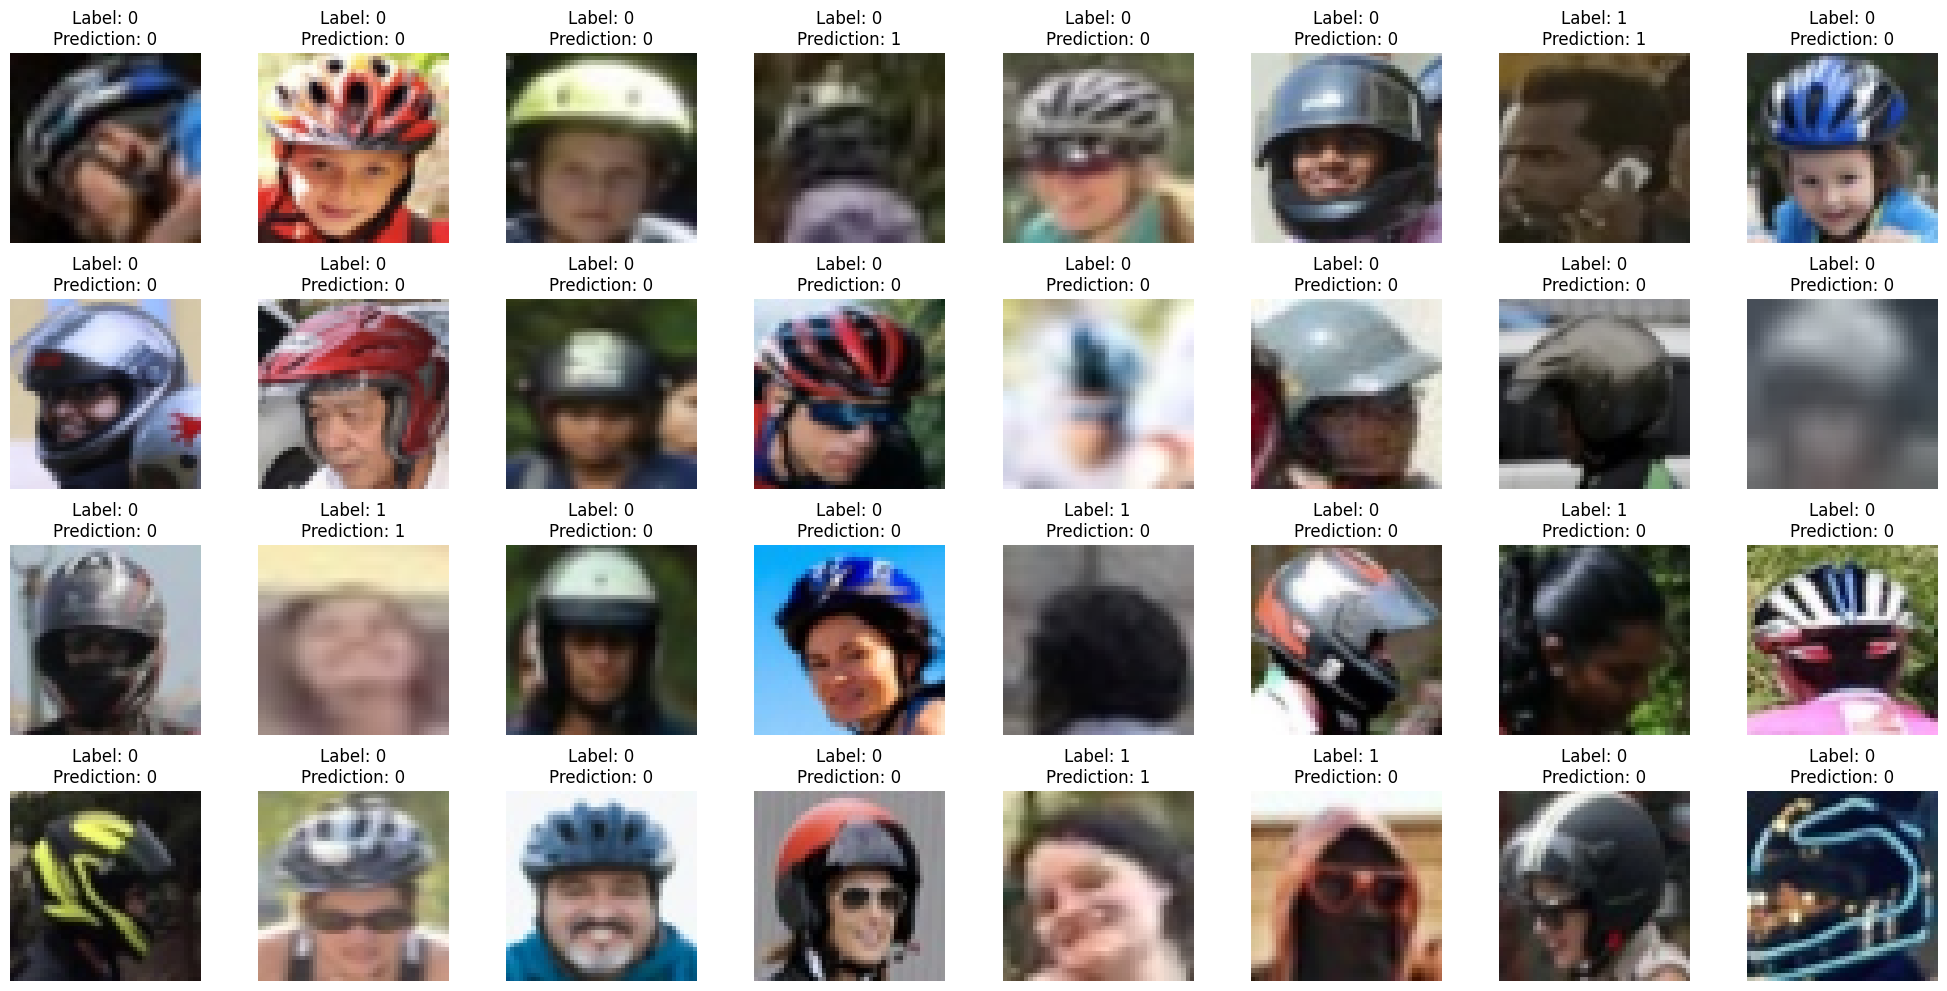

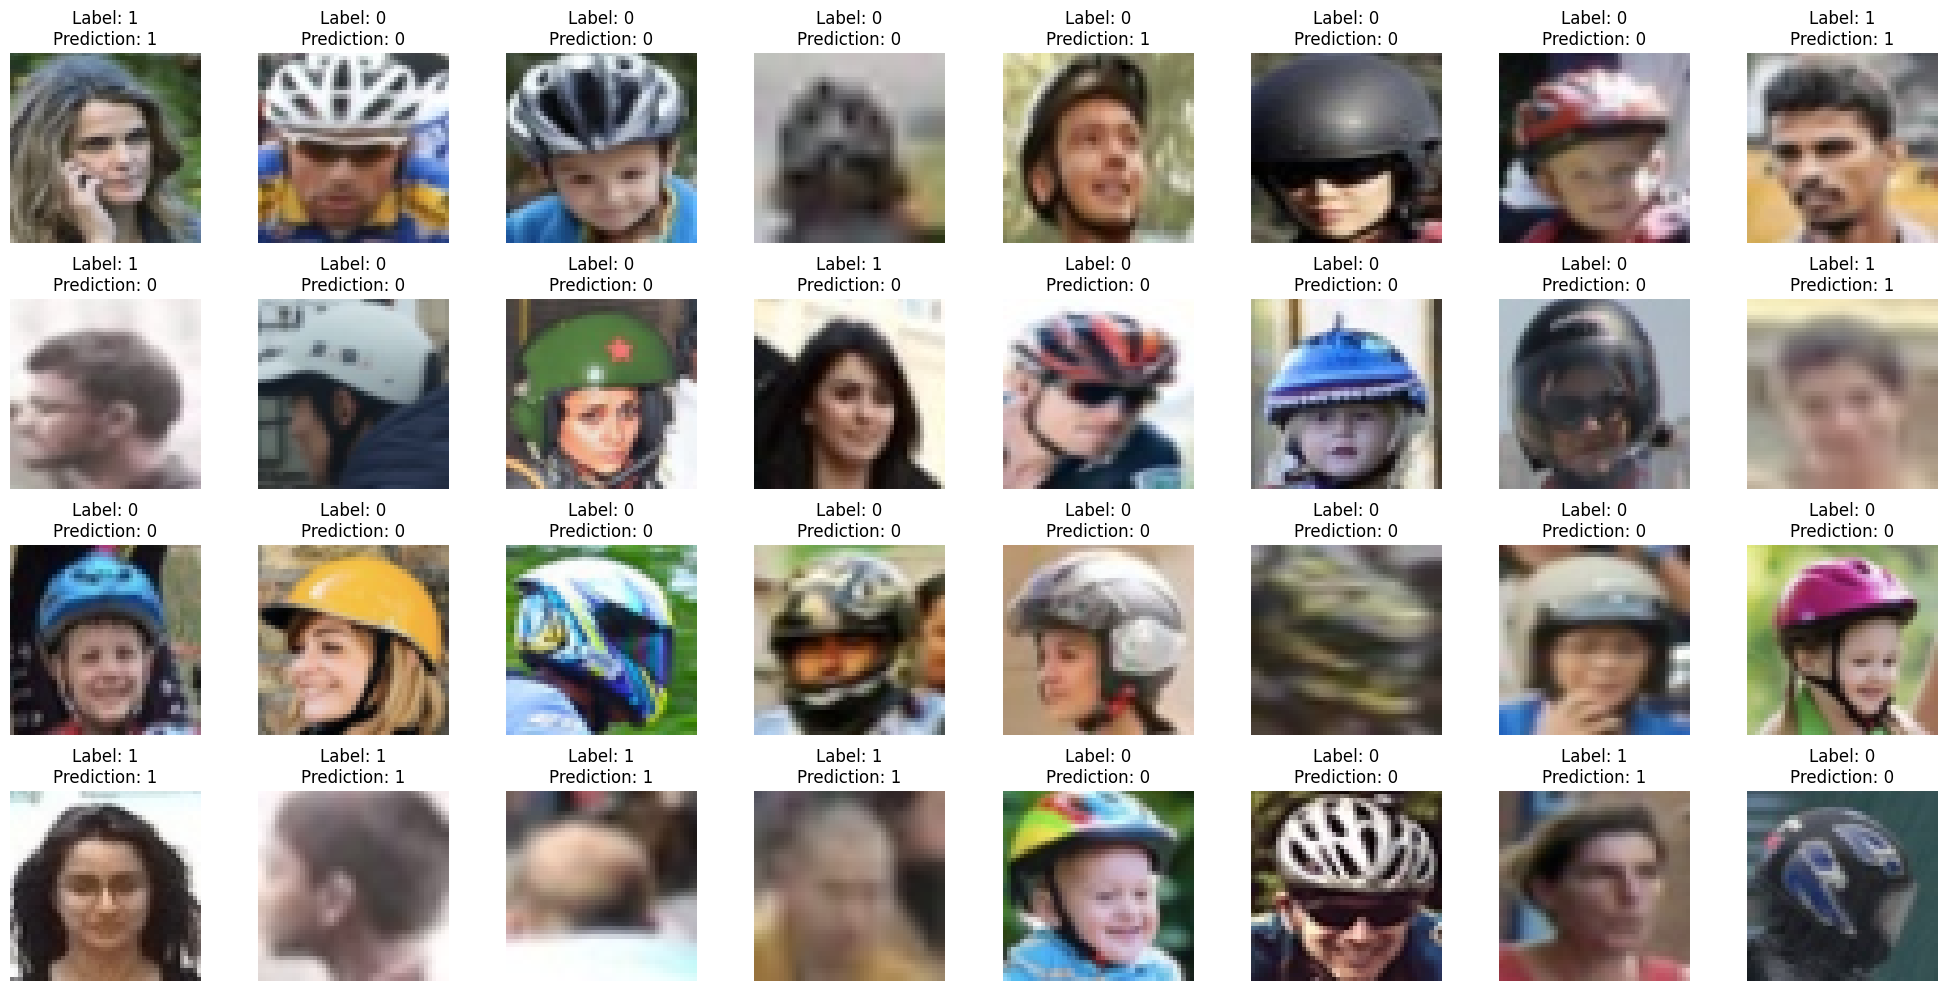

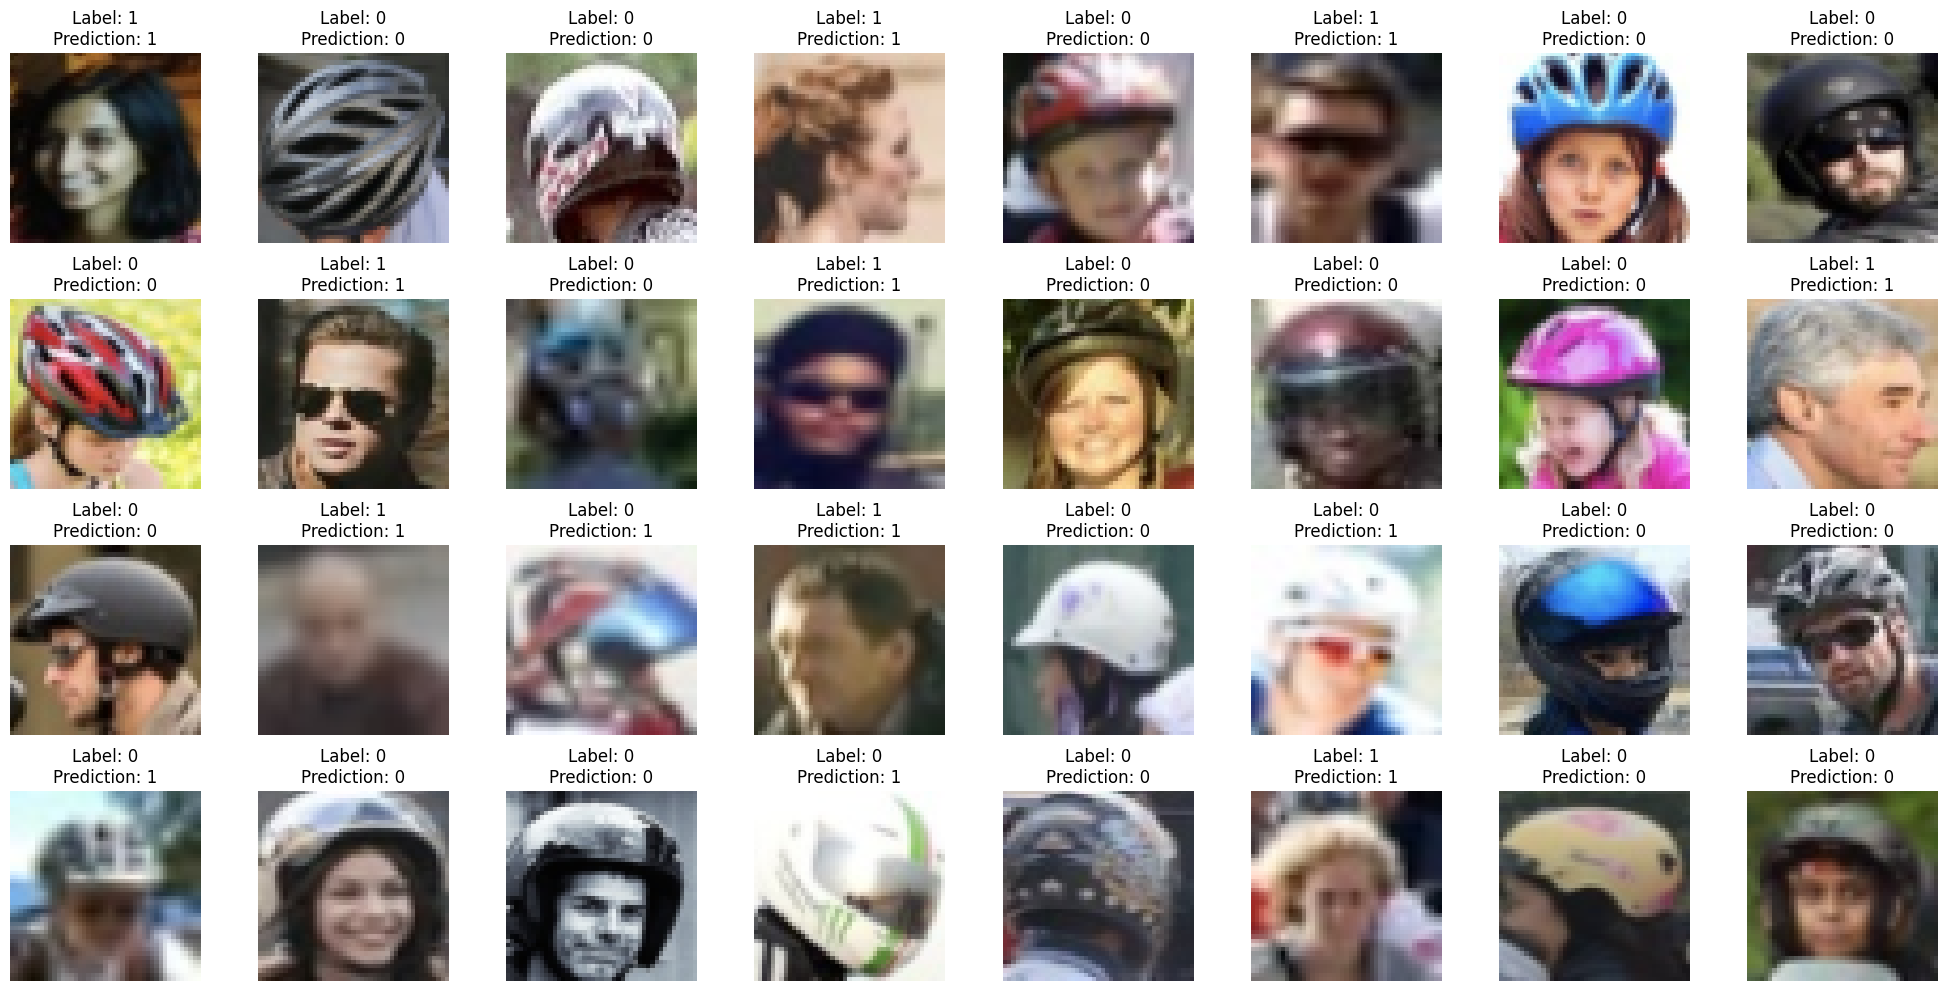

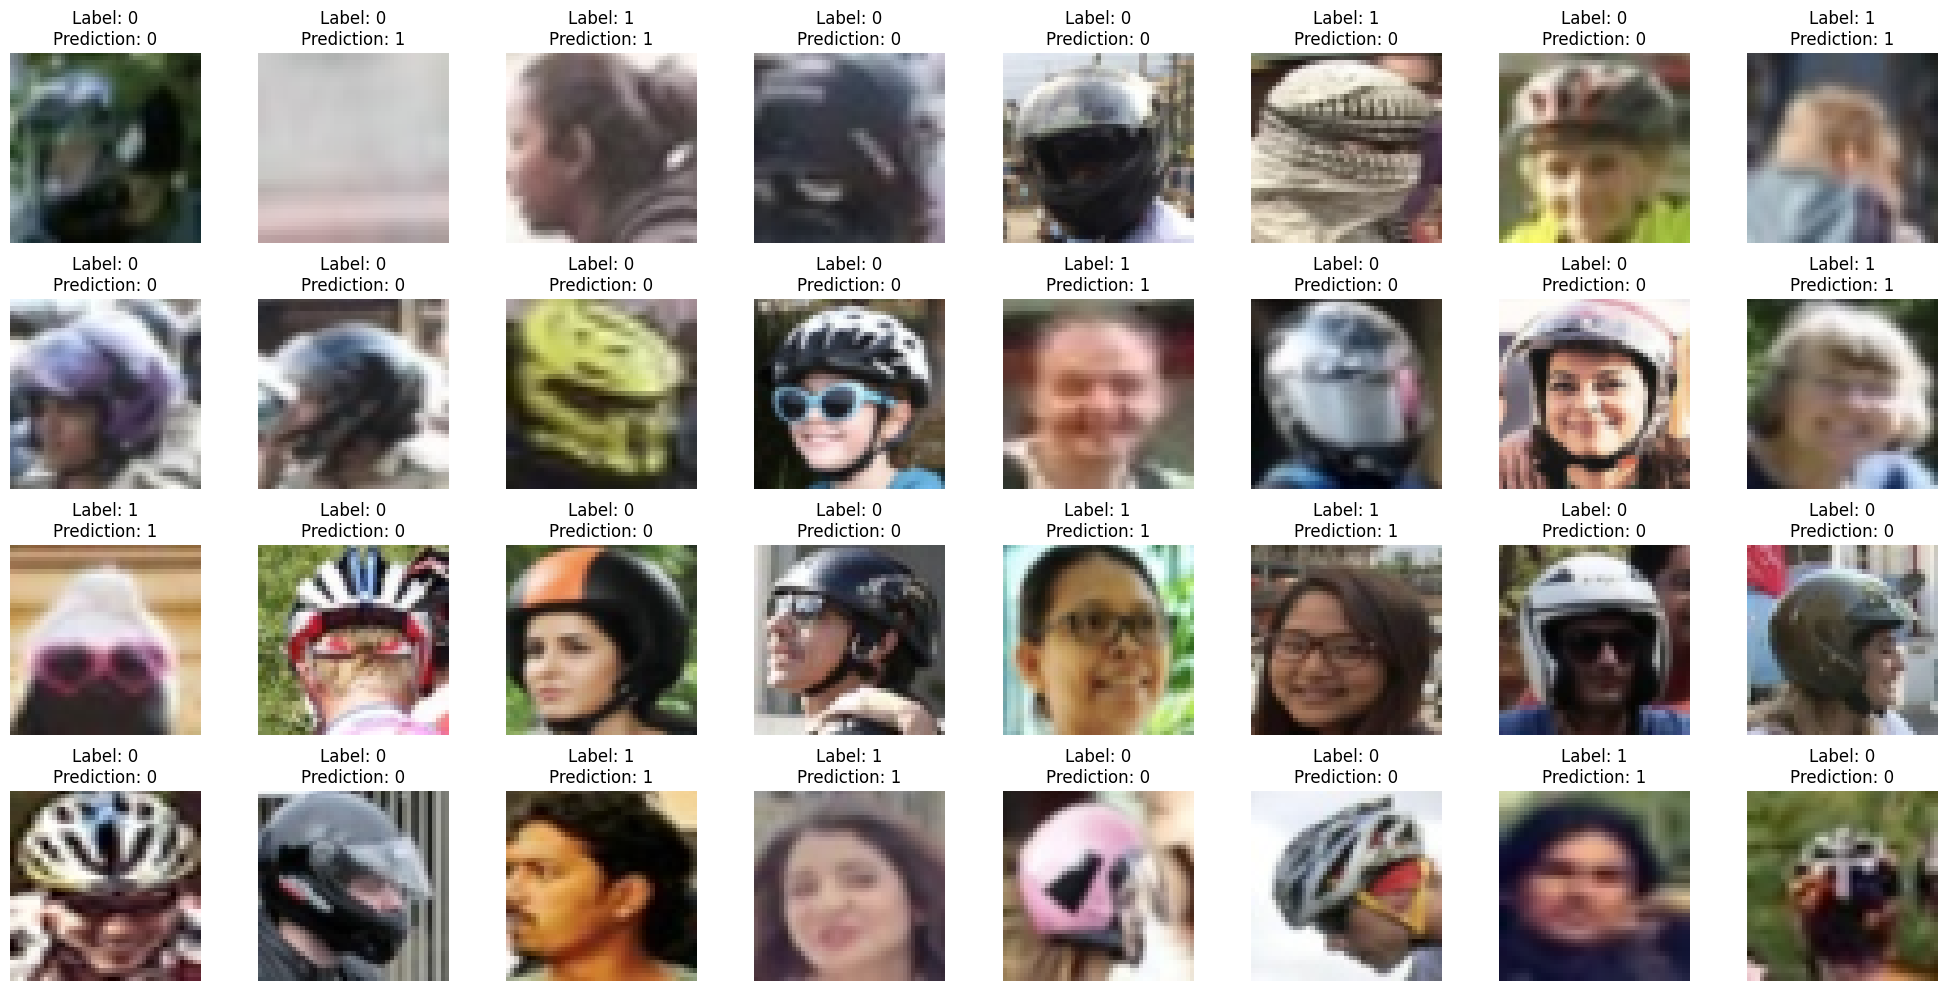

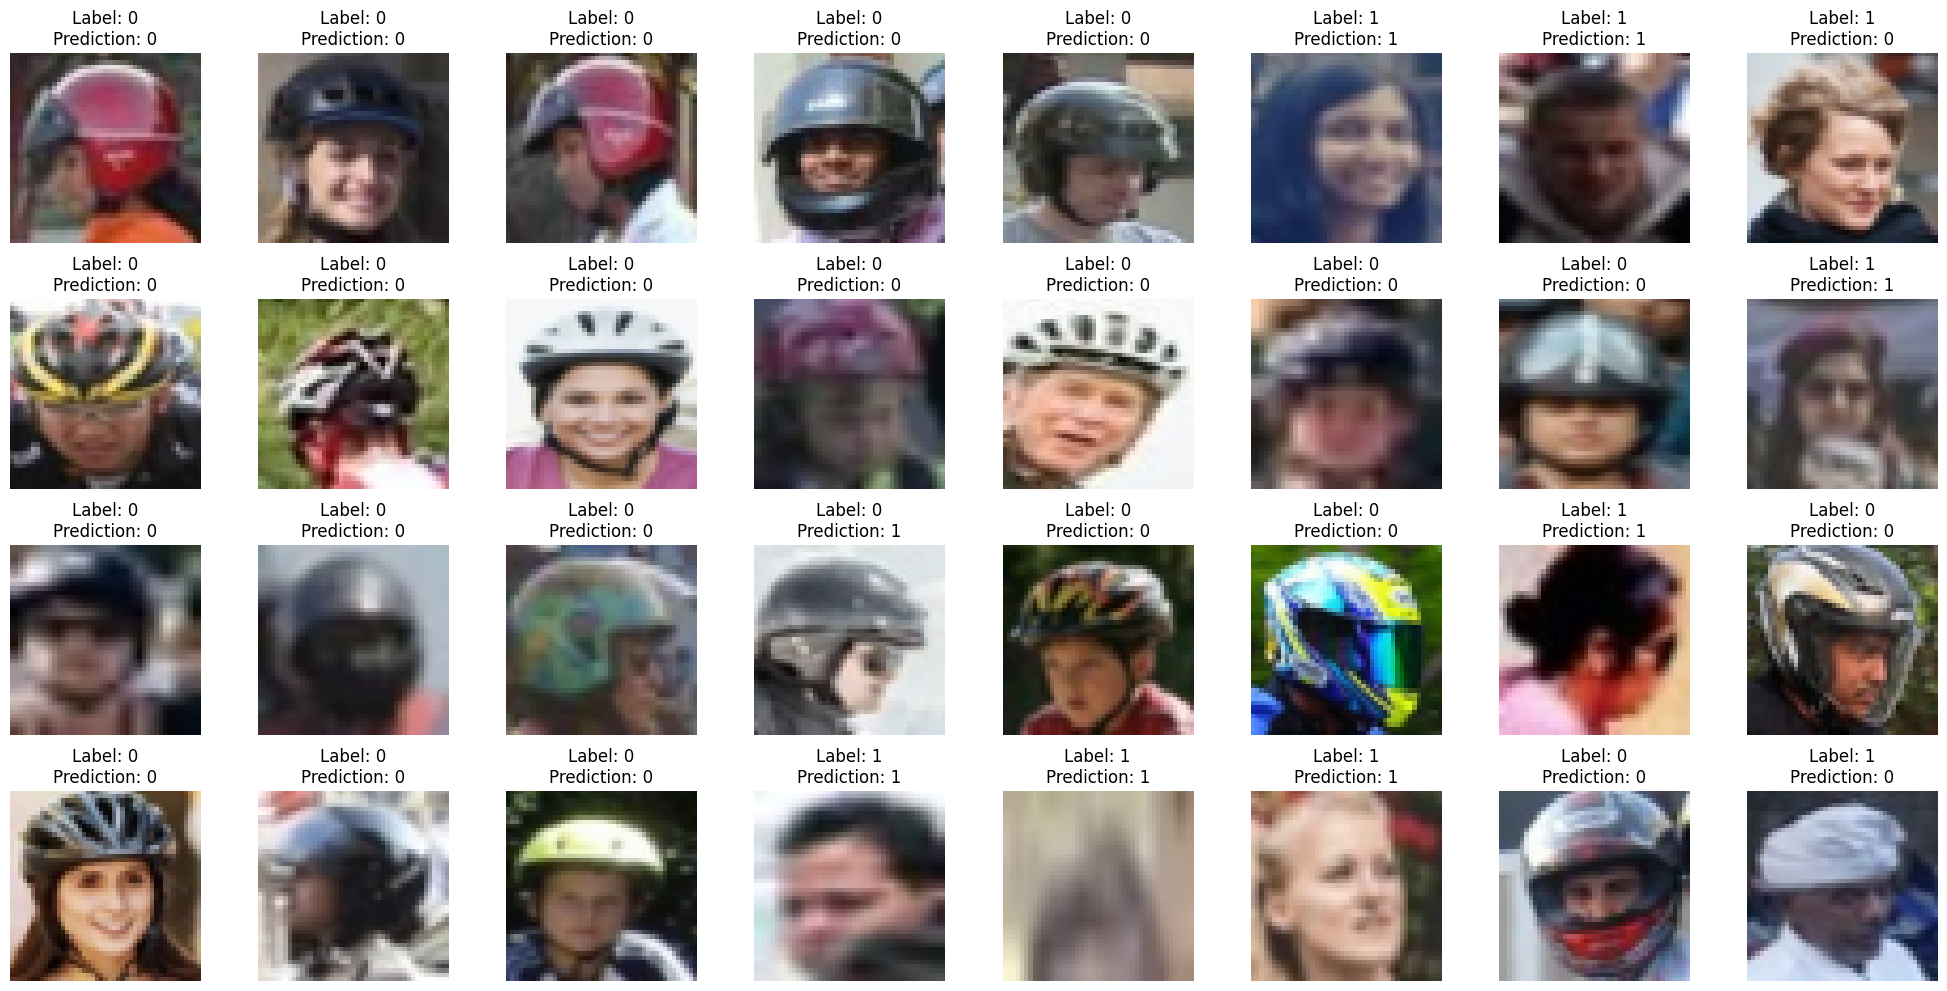

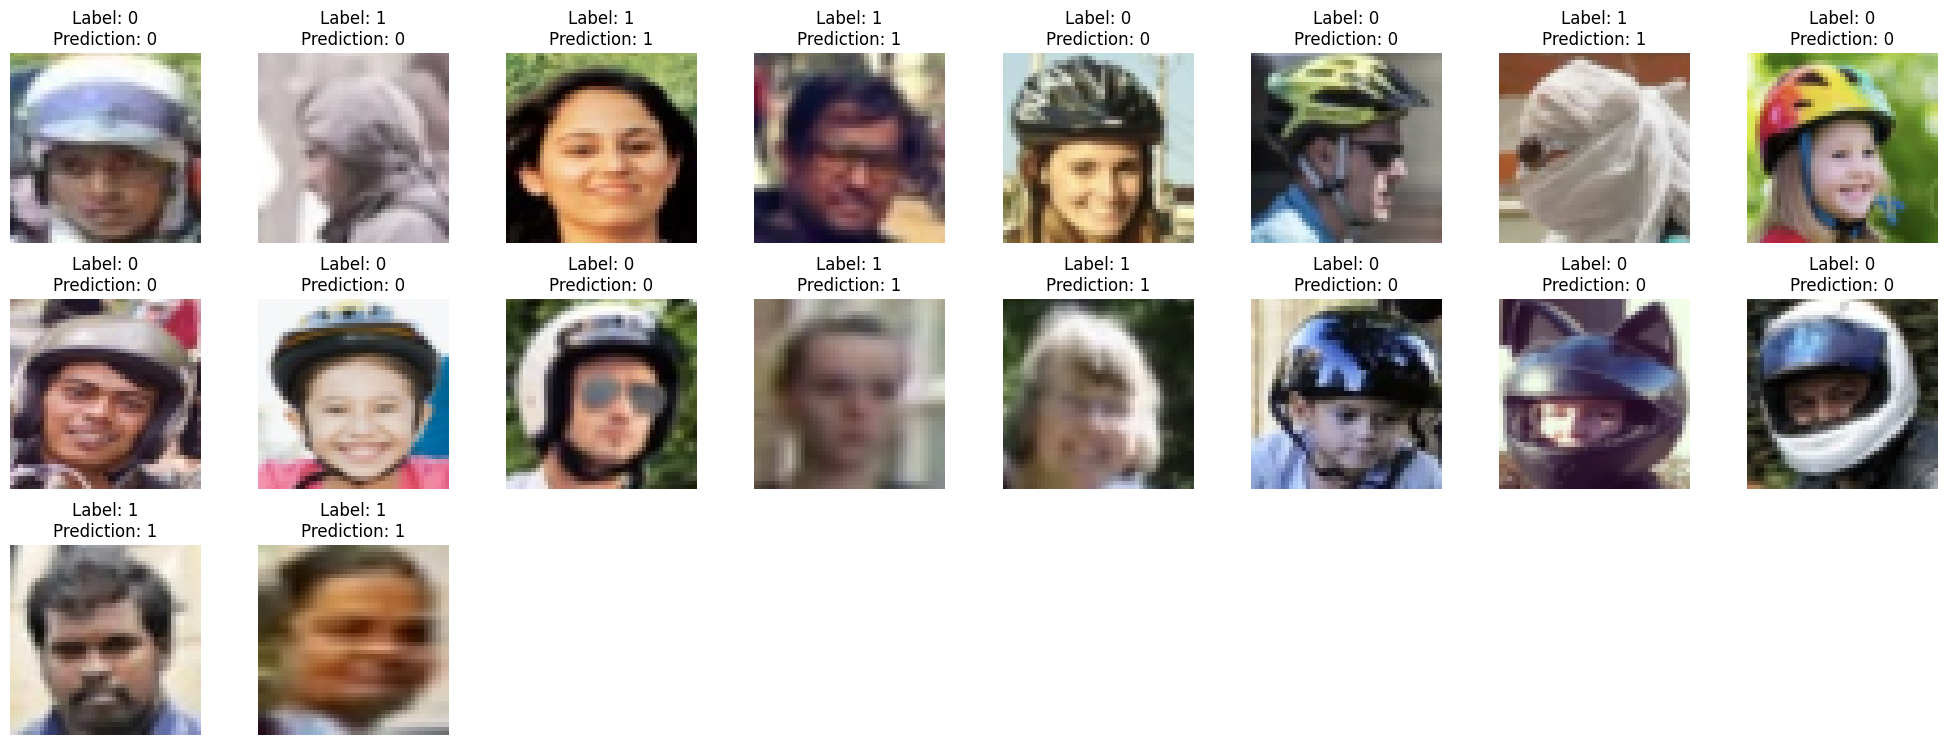

In [25]:
model_1 = ObjectClassifier(2, [(16, 3), (32, 3)], dropout_p=0.4)
model_1.load_state_dict(torch.load('models/model_1.pt'))


test_dataset = ObjectDataset(X_test, y_test, transform=image_loader_resizer)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

test_loss = 0
test_accuracy = 0
model_1.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_1(images)
        loss = criterion(log_ps, labels)
        test_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    print(f"Test loss: {test_loss/len(test_dataloader):.3f}.. "
          f"Test accuracy: {test_accuracy/len(test_dataloader):.3f}")
    
    k = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model_1(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        images = images.to(device)
        labels = labels.to(device)
        top_class = top_class.to(device)
        equals = equals.to(device)
        plt.figure(figsize=(20, 10)) 
        for i in range(32):
            
            plt.subplot(4, 8, i+1)
            plt.imshow(images[i].cpu().permute(1, 2, 0))
            plt.title(f"Label: {labels[i].item()}\nPrediction: {top_class[i].item()}")
            plt.axis('off')
            if i >= len(images) - 1:
                break
        plt.tight_layout()
        plt.savefig(f'output/final_predictions_{k}.png', dpi=300)
        plt.show()
        k += 1



In [26]:
# Save the model visualization
from torchviz import make_dot

x = torch.randn(1, 3, 45, 45).requires_grad_(True)
y = model_1(x)
dot = make_dot(y.mean(), params=dict(model_1.named_parameters()))
dot.format = 'png'
dot.render('output/model_1_graph')


'output/model_1_graph.png'